In [1]:
# to use this notebook you'll need to have this env running: /raid9/oriana/envs/plotting

In [33]:
%matplotlib inline

import os
import itertools
from collections import OrderedDict

import numpy as np
import xarray as xr
import pandas as pd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from scipy.ndimage.measurements import center_of_mass
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from bmorph.io.tip304 import get_model_ts, get_nrni_ts_csv


In [3]:
xr.__version__

'0.9.6'

In [4]:
def load_rmjoc():
    da = xr.open_dataset('/raid3/oriana/bpa/future/rmjoc_streamflow_09.nc')['streamflow']
    da['rcp'] = [r.lower() for r in da['rcp'].values]
    da['gcm'] = [g.lower() for g in da['gcm'].values]

    return da

In [5]:
da_rmjoc = load_rmjoc()
da_rmjoc

<xarray.DataArray 'streamflow' (time: 54787, outlets: 377, parameters: 4, downscale_method: 2, gcm: 10, rcp: 2)>
[3304751840 values with dtype=float64]
Coordinates:
  * rcp               (rcp) <U5 'rcp45' 'rcp85'
  * downscale_method  (downscale_method) object 'bcsd' 'maca'
  * time              (time) datetime64[ns] 1950-01-01 1950-01-02 1950-01-03 ...
  * gcm               (gcm) <U13 'hadgem2-cc' 'hadgem2-es' 'canesm2' ...
  * outlets           (outlets) |S256 b'MCD' b'GOLDS' b'DONAL' b'BEAVE' ...
  * parameters        (parameters) object 'PRMS' 'calib_inverse' 'ORNL' 'NCAR'

In [42]:
# metrics

def metric_annual_streamflow(da, historical_slice, future_slice, percent_change=True):
    
    da_change = da.sel(time=future_slice).mean(dim='time') - da.sel(time=historical_slice).mean(dim='time')
    
    if percent_change:
        # percent change relative to historic period
        return da_change / da.sel(time=historical_slice).mean(dim='time') * 100
    else:
        return da_change
        
    
def metric_season_streamflow(da, historical_slice, future_slice, percent_change=True, season='JJA'):
    
    da_seas = da.sel(time=(da['time.season'] == season))
    
    da_change = da_seas.sel(time=future_slice).mean(dim='time') - da_seas.sel(time=historical_slice).mean(dim='time')
    
    if percent_change:
        # percent change relative to historic period
        return da_change / da.sel(time=historical_slice).mean(dim='time') * 100
    else:
        return da_change 
    
    return    

def apply_center_of_mass(da, dim='dayofyear'):
    axis = da.get_axis_num(dim)
    dims = list(da.dims)
    dims.remove(dim)

    coords = dict(da.coords)
    _ = coords.pop(dim)
    
    centroids = np.apply_along_axis(center_of_mass, axis, da.values).squeeze()

    centroids_da = xr.DataArray(centroids, dims=dims, coords=coords)
    return centroids_da


def metric_change_in_centroid_of_timing(da, historical_slice, future_slice):
    da_his = da.sel(time=historical_slice).groupby('time.dayofyear').mean('time')
    da_fut = da.sel(time=future_slice).groupby('time.dayofyear').mean('time')
    
    change = apply_center_of_mass(da_fut, 'dayofyear') - apply_center_of_mass(da_his, 'dayofyear')
    
    return change

def metric_change_in_days_streamflow(da, day1='1975-10-01', day2='1975-10-02'):
    change = da.sel(time=day1)/da.sel(time=day2)
    
    return change

In [7]:
def calc_anova_variance(df):
    model = ols("change ~ parameters + downscale_method + gcm + rcp", df).fit()
    table = anova_lm(model, typ=2) # Type 2 ANOVA DataFrame
    return table.sum_sq.divide(table.sum_sq.sum()) * 100

In [53]:
fig_dir='/home/ftp/pub/oriana/qualifying_exam/jessica/'
os.makedirs(fig_dir, exist_ok=True)

In [71]:
hist_slice = slice('1970', '1999')
fut_slice = slice('2070', '2099')
names = [b'TDA', b'CHL']

results = OrderedDict()
for (title, func, kwargs) in [('Change in Annual Streamflow', metric_annual_streamflow, {}),
                              ('Change in Centroid of Timing', metric_change_in_centroid_of_timing, {})]:
    results[title] = OrderedDict()
    for name in names:
        print(title)
        rm_da =  func(da_rmjoc.sel(outlets=name), hist_slice, fut_slice, **kwargs)
        rm_df = rm_da.drop('outlets').to_dataframe(name='change').reset_index()

        df_all = pd.concat([rm_df]).dropna()
        
        df_test = df_all[(df_all.rcp != 'rcp26')]
        
        results[title][name] = calc_anova_variance(df_test)
        
    results[title] = pd.DataFrame(results[title])


Change in Annual Streamflow
Change in Annual Streamflow
Change in Centroid of Timing
Change in Centroid of Timing


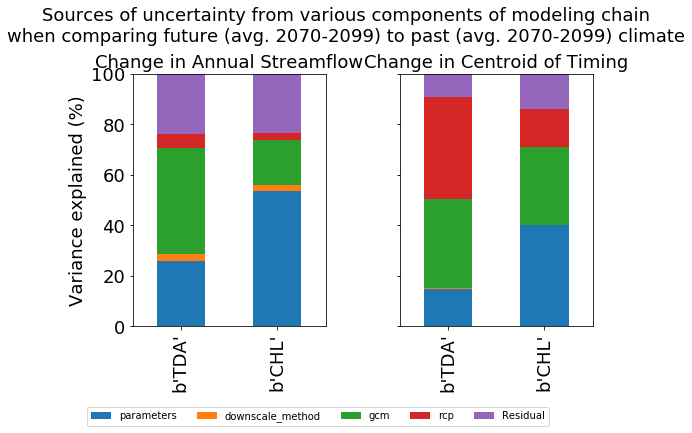

In [50]:
fontsize=18
fig, axes = plt.subplots(1,2, figsize=(8, 5), sharex=True, sharey=True)
for ax, (title, df) in zip(axes.flat, results.items()):
    df.T.plot.bar(stacked=True, ax=ax, legend=False)
    ax.set_title(title, fontsize=fontsize)
    ax.set_ylim(0, 100)
ax.legend(ncol=5, loc='bottom', bbox_to_anchor=(0.8, -0.3))

_ = [ax.set_ylabel('Variance explained (%)', fontsize=fontsize) for ax in axes[:]]
_ = [ax.tick_params(labelsize=fontsize) for ax in axes[:]]
plt.suptitle('Sources of uncertainty from various components of modeling chain\n'
          'when comparing future (avg. 2070-2099) to past (avg. 2070-2099) climate', fontsize=fontsize, y=1.1)
fig.tight_layout()
fig.savefig(fig_dir+'variance_explained_future_climate.png')

In [72]:
hist_slice = slice('1970', '1999')
fut_slice = slice('2070', '2099')
names = [b'TDA', b'CHL']

results_daily = OrderedDict()
for (title, func, kwargs) in [("Change in streamflow from October 1 to October 2, 1978", metric_change_in_days_streamflow, {})]:
    results_daily[title] = OrderedDict()
    for name in names:
        print(title)
        rm_da =  func(da_rmjoc.sel(outlets=name), day1='1975-10-01', day2='1975-10-02', **kwargs)
        rm_df = rm_da.drop('outlets').to_dataframe(name='change').reset_index()

        df_all = pd.concat([rm_df]).dropna()
        
        df_test = df_all[(df_all.rcp != 'rcp26')]
        
        results_daily[title][name] = calc_anova_variance(df_test)
        
    results_daily[title] = pd.DataFrame(results_daily[title])

Change in streamflow from October 1 to October 2, 1978
Change in streamflow from October 1 to October 2, 1978


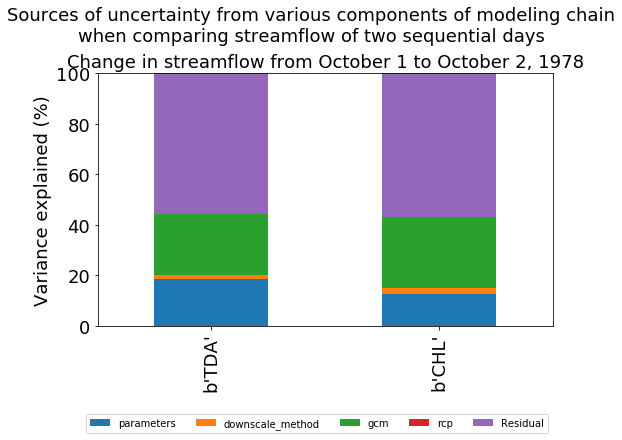

In [104]:
fontsize=18
fig, ax = plt.subplots(1,1, figsize=(8, 5), sharex=True, sharey=True)
[title] = results_daily.keys()
df = results_daily[title]
df.T.plot.bar(stacked=True, ax=ax, legend=False)
ax.set_title(title, fontsize=fontsize)
ax.set_ylim(0, 100)
ax.legend(ncol=5, loc='bottom', bbox_to_anchor=(1,-0.33))

ax.set_ylabel('Variance explained (%)', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
plt.suptitle('Sources of uncertainty from various components of modeling chain\n'
          'when comparing streamflow of two sequential days', fontsize=fontsize, y=1.1)
fig.tight_layout()

# fig.subplots_adjust(top=0.75, bottom=.1)
fig.savefig(fig_dir+'variance_explained_two_sequential_days.png')

# Checking to see whether a change had a statistically significant improvement on the simulation

In [29]:
def kge(sim, obs, timestep):
    '''
    Calculate the Kling-Gupta Efficiency
       
    Parameters
    ----------
    sim, obs : Pandas.Series
        Series to calculate the overlap statistic on
    timestep : str, likely either 'D' or 'W'
    
    Returns
    -------
    kge : float
        KGE calculated from sim and obs
    '''
#     sim = remove_nans(sim.resample(timestep, how='mean'))
#     obs = remove_nans(obs.resample(timestep, how='mean'))
    std_sim = np.std(sim)
    std_obs = np.std(obs)
    mean_sim = sim.mean(axis=0)
    mean_obs = obs.mean(axis=0)
    r_array = np.corrcoef(sim,obs)
    r = r_array[0,1]
    relvar = std_sim/std_obs
    bias = mean_sim/mean_obs
    kge = 1-np.sqrt(np.square(r-1) + np.square(relvar-1) + np.square(bias-1))
    return kge

In [14]:
nrni_file = '/raid9/oriana/bpa/nrni/NRNI_20170410/NRNI_Flows_1929-2008_Corrected_04-2017.csv'
site = 'HGH'
hydro_model = 'VIC'
parameter_set = 'P2'

#for gcm in ['M']
original_version='streamflow-provisional_0.9'

original_file_name = '{}_{}_{}-{}-{}.csv'.format('historical_livneh', hydro_model, parameter_set, site, original_version)
original_file = '/raid3/oriana/bpa/future/{}/ORNL/historical/deliverables/historical_livneh-{}/streamflow/{}'.format(hydro_model, 
                                     original_version, original_file_name )

fixed_version='streamflow-provisional_0.10'

fixed_file_name = '{}_{}_{}-{}-{}.csv'.format('historical_livneh', hydro_model, parameter_set, site, fixed_version)
fixed_file = '/raid3/oriana/bpa/future/{}/ORNL/historical/deliverables/historical_livneh-{}/streamflow/{}'.format(hydro_model, 
                                     fixed_version, fixed_file_name )

nrni = get_nrni_ts_csv(site, nrni_file)
original = get_model_ts(original_file)
fixed = get_model_ts(fixed_file)

In [ ]:
# loop through and calculate the KGE for each year of the 62 year time series

In [31]:
original_kges, fixed_kges = [], []
for year in np.arange(1950,2007):
    original_kges.append(kge(original.truncate(before='10-01-'+str(year), after='09-30-'+str(year+1)), 
                             nrni.truncate(before='10-01-'+str(year), after='09-30-'+str(year+1)), 'D'))
    fixed_kges.append(kge(fixed.truncate(before='10-01-'+str(year), after='09-30-'+str(year+1)), 
                          nrni.truncate(before='10-01-'+str(year), after='09-30-'+str(year+1)), 'D'))

In [35]:
ttest = stats.ttest_ind(original_kges, fixed_kges)
print('ttest results are', ttest)

ttest results are Ttest_indResult(statistic=-47.152026894625507, pvalue=1.0368582058483937e-75)


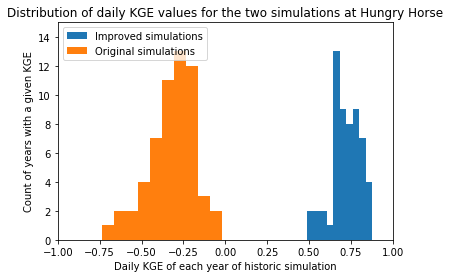

In [55]:
# plot the distribution of KGE values
plt.hist(fixed_kges, label='Improved simulations')
plt.hist(original_kges, label='Original simulations')
plt.title('Distribution of daily KGE values for the two simulations at Hungry Horse')
plt.ylim(0,15)
plt.xlim(-1.0, 1.0)
plt.ylabel('Count of years with a given KGE')
plt.xlabel('Daily KGE of each year of historic simulation')
plt.legend(loc='upper left')
plt.savefig(fig_dir+'distribution_of_kges.png')